<a href="https://colab.research.google.com/github/xs912/Speech-recognition/blob/main/Speech_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Speech recognition**



In [ ]:
!pip install git+https://github.com/librosa/librosa 

  Cloning https://github.com/librosa/librosa to /tmp/pip-req-build-vlf3smij
  Running command git clone -q https://github.com/librosa/librosa /tmp/pip-req-build-vlf3smij
  Created wheel for librosa: filename=librosa-0.8.0-cp36-none-any.whl size=201373 sha256=c7d62237036d0d9f583ff634b9cc876384f6316a63cdea062cd8eb4fbd6d1553
  Stored in directory: /tmp/pip-ephem-wheel-cache-j6oh8_xe/wheels/ff/3e/4c/a872019d317d55de16e91a60bee1fb10a6404d1edb91fb4318
Successfully built librosa


In [ ]:
import numpy as np 
from matplotlib import pyplot as plt 
from IPython.display import Audio # модуль для обращения к HTML для записи аудио с микрофона в ноутбуке
from google.colab import files 
import librosa 
import os 
from sklearn.model_selection import train_test_split 
from keras.utils import to_categorical 
from tqdm import tqdm 
from keras.optimizers import Adam, RMSprop, Adadelta 
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Reshape 
import IPython.display as ipd 

In [ ]:
from google.colab import drive # 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*Объявление функций*



In [ ]:
DATA_PATH = "/content/drive/My Drive/comands/" #  путь к папке с аудиофайлами
DATA_PATH_TEST = "/content/drive/My Drive/test_speech/" #  путь к файлу с тестовыми 30-секундными аудиофайлами

sample_rate = 22050 # Значение sample_rate аудиофайлов
feature_dim_1 = 20 # стандартная величина MFCC признаков
feature_dim_2 = int(.5 * sample_rate) # установленная длина фреймов (в секундах 0.5 = 500 мс)
step_mfcc = int(.02 * sample_rate) # Шаг смещения при разборе mfcc (в секундах 0.1 = 100мс)
channel = 1 # количество каналов
n_classes = 4 # Количество классов команд
classes = ['КОНДИЦИОНЕР', 'СВЕТ', 'ТЕЛЕВИЗОР'] # Классы команд (без фона)


In [ ]:
'''
Функция извлечения меток классов и их обработки
  Параметры:
    path - путь к папке, в которой находятся каталоги с обучающими командами    
'''
def get_labels(path=DATA_PATH): 
  labels = sorted(os.listdir(path))   
  label_indices = np.arange(0, len(labels)) 
  return labels, label_indices, to_categorical(label_indices) 

In [ ]:
l,_,_ = get_labels()
l

['1_cond', '2_light', '3_tv', '4_noise']

In [ ]:
'''
Функция параметризации аудио (wav в мел-частоты)
  Параметры:
    length - длина отрезков, на которые разбиваем исходный файл
    step - шаг, на который смещаем разбиение отрезка
'''

def wav2mfcc(file_path, length = 11025, step = 2205): 
  out_mfcc = [] 
  out_audio = [] 
  y, sr = librosa.load(file_path)  

  while (len(y)>=length):  
    section = y[:length] 
    section = np.array(section) 
    out_mfcc.append(librosa.feature.mfcc(section, sr)) 
    out_audio.append(section) 
    y = y[step:]  
    
  out_mfcc = np.array(out_mfcc) 
  out_audio = np.array (out_audio) 
  return out_mfcc, out_audio # массив мел-частот и массив аудио-отрезков

In [ ]:
'''
Функция формирования и сохранения векторов данных, полученных для каждого набора аудиокоманд в датасете
  Параметры:
    path  - путь к папке, в которой находятся каталоги с обучающими командами    
    length - длина отрезков, на которые разбиваем исходный файл
'''

def save_data_to_array(path=DATA_PATH, length=11025):
  labels, _, _ = get_labels(path) 
  for label in labels: 
    mfcc_vectors = [] 
    wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
    for wavfile in tqdm(wavfiles, "Сохраняем векторы класса - '{}'".format(label)): 
      mfcc, _ = wav2mfcc(wavfile, length=length, step = step_mfcc)      
      if (mfcc.shape[0] != 0 ): 
        mfcc_vectors.extend(mfcc) # 
    np.save('/content/drive/My Drive/numpy/'+ label + '.npy', mfcc_vectors) 

In [ ]:
'''
Функция для получения обучающей/проверочной выборки
  Параметры (необязательные):
    split_ratio - (1-split_ratio) равно доле тестовых образцов, которые вернет функция train_test_split
    random_state - начальное число, используемое генератором случайных чисел в функции train_test_split
'''

def get_train_test(split_ratio=0.7, random_state=42, colab = True):
  labels, indices, _ = get_labels(DATA_PATH) 

  X = np.load('/content/drive/My Drive/numpy/'+labels[0] + '.npy') 
  y = np.zeros(X.shape[0], dtype = 'int32') 

  for i, label in enumerate(labels[1:]): 
    if colab:
      x = np.load(label + '.npy') 
    else:
      x = np.load('/content/drive/My Drive/numpy/'+label + '.npy') 
    X = np.vstack((X, x)) 
    y = np.append(y, np.full(x.shape[0], fill_value= (i + 1))) 

  return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True) 

*Подготовка данных*

In [ ]:
save_data_to_array(length=feature_dim_2)

Сохраняем векторы класса - '4_noise': 100%|██████████| 50/50 [07:09<00:00,  8.60s/it]


In [ ]:
##########################
# Формирование обучающей и проверочной выборок
##########################
x_train, x_test, y_train, y_test = get_train_test(colab=False) 
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(56626, 20, 22) (56626,)
(24269, 20, 22) (24269,)


In [ ]:
x_train = x_train[..., None]
x_test = x_test[..., None]

y_train_hot = to_categorical(y_train) 
y_test_hot = to_categorical(y_test) 

In [ ]:
idx = np.where(y_train==3)
idx[0].shape

(50778,)

*Нейросеть*

In [ ]:
##########################
# Функция создания модели нейросети
##########################
def get_model():
  model = Sequential()
  model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], channel)))
  model.add(MaxPooling2D(pool_size=(2, 2)))  
  model.add(BatchNormalization())
  model.add(Flatten())  
  model.add(Dense(128, activation='relu')) 
  model.add(Dropout(0.25)) 
  model.add(BatchNormalization()) 
  model.add(Dense(n_classes, activation='softmax')) 
  model.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy']) 
  return model

In [ ]:
model = get_model() 

Epoch 1/50
222/222 [==============================] - 1s 5ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0017 - val_accuracy: 0.9993
Epoch 2/50
222/222 [==============================] - 1s 5ms/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.0048 - val_accuracy: 0.9990
Epoch 3/50
222/222 [==============================] - 1s 4ms/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.0050 - val_accuracy: 0.9988
Epoch 4/50
222/222 [==============================] - 1s 5ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 0.0046 - val_accuracy: 0.9990
Epoch 5/50
222/222 [==============================] - 1s 4ms/step - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.0041 - val_accuracy: 0.9988
Epoch 6/50
222/222 [==============================] - 1s 5ms/step - loss: 0.0043 - accuracy: 0.9985 - val_loss: 0.0028 - val_accuracy: 0.9993
Epoch 7/50
222/222 [==============================] - 1s 5ms/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.0029 - val_accuracy: 0.9995
Epoch 

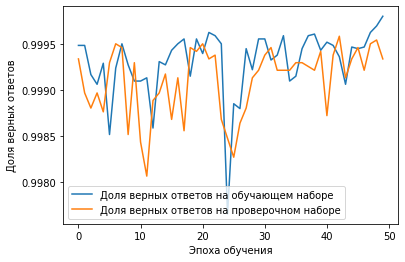

In [ ]:
##########################
# Тренировка нейросети на полученных данных
##########################

history = model.fit(x_train, y_train_hot, batch_size=256, epochs=50, verbose=1, validation_data=(x_test, y_test_hot))

plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

*Проверка*

In [ ]:
wavfiles =  DATA_PATH_TEST + 'text_with_cond1.wav' 
y,sr = librosa.load(wavfiles) 
print ('Оригинальный файл:')
ipd.Audio(data=y, rate = sr) 

Оригинальный файл:


*Функция*



In [ ]:
##########################
# Функция предсказания команды
##########################
def predict(namefile, model, min_count = 2, rate = 0.9, hole = 1): 
  mfcc_full, audio_full = wav2mfcc (namefile, length=feature_dim_2, step = step_mfcc)    
  mfcc_full = mfcc_full.reshape(-1, 20, 22, 1)
  g_pred = model.predict(mfcc_full) 
  pred = np.array([np.argmax(i) for i in g_pred])
  out = [] 
  for idx_class in range(n_classes-1):
    idxs = np.where(pred == idx_class) 
    idxs = idxs[0] 
    if (len(idxs) == 0): 
      continue 

    curr = [] 
    curr_idx =int(idxs[0]) 
    summ, length = 0, 0 
    for i in range(len(idxs)): 
      summ += g_pred[idxs[i]][idx_class] 
      length += 1
      if i == len(idxs)-1: 
        if (length >= min_count and summ / length >= rate): 
          curr.append([curr_idx, length, summ / length]) 

        break  
      if idxs[i+1]-idxs[i]>hole: 
        if (length >= min_count and summ / length >= rate): 
          print(length)
          curr.append([curr_idx, length, summ / length])  
        curr_idx = int (idxs[i+1]) 
        summ, length = 0, 0 
    curr_audio = [] 
    for elem in curr: 
     
      curr_audio = audio_full[elem[0]] 
      for j in range(1,elem[1]): 
        if (elem[0]+j == len(audio_full)): 
          break
        
        curr_audio = np.hstack((curr_audio, audio_full[elem[0]+j][-step_mfcc:]))
      curr_audio = np.array(curr_audio) 
      out.append([curr_audio, idx_class, elem[2]]) 
  return out, pred, g_pred 

Распознавание записанных команд

In [ ]:
DATA = '/content/drive/My Drive/'

In [ ]:
wavfiles =  DATA + '1_cond/0_cond.wav' 
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.9, hole = 2)   
if (len(out)==0): 
  print('Команда не распознана!!!')
for elem in out: 
  print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2]*100), '%)')  

Распознана команда: " КОНДИЦИОНЕР " (вероятность - 99.91 %)


In [ ]:
wavfiles =  DATA + '3_tv/0_tv.wav' 
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.9, hole = 2)   
if (len(out)==0): 
  print('Команда не распознана!!!')
for elem in out: 
  print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2]*100), '%)')

Распознана команда: " ТЕЛЕВИЗОР " (вероятность - 99.70 %)


In [ ]:
wavfiles =  DATA + '2_light/0_light.wav' 
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.9, hole = 2)   
if (len(out)==0): 
  print('Команда не распознана!!!')
for elem in out: 
  print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2]*100), '%)')

34
Распознана команда: " СВЕТ " (вероятность - 99.78 %)
Распознана команда: " СВЕТ " (вероятность - 99.98 %)


*Распознавание команд на обновленной базе (дополненной записанными голосовыми командами)*

In [ ]:
wavfiles =  DATA_PATH_TEST + 'text_with_cond3.wav' 
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.9, hole = 2)   
if (len(out)==0): 
  print('Команда не распознана!!!')
for elem in out: 
  print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2]*100), '%)') 


27
Распознана команда: " КОНДИЦИОНЕР " (вероятность - 99.15 %)


In [ ]:
wavfiles =  DATA_PATH_TEST + 'text_with_televizor2.wav' 
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.9, hole = 2)   
if (len(out)==0): 
  print('Команда не распознана!!!')
for elem in out: 
  print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2]*100), '%)') 



20
Распознана команда: " ТЕЛЕВИЗОР " (вероятность - 99.50 %)


In [ ]:
wavfiles =  DATA_PATH_TEST + 'text_with_svet1.wav' 
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.9, hole = 1)  
if (len(out)==0): 
  print('Команда не распознана!!!')
for elem in out: 
  print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2]*100), '%)') 
 


Распознана команда: " СВЕТ " (вероятность - 99.48 %)


1. Сеть показала хорошие результаты распознавания записанных аналогичных команд. Все команды были записаны правильно. 
2. В текущую базу были добавлены по 5 команд каждого класса, записанные моим голосом, после чего результаты работы сети были проверены на обновленной базе. В данном случае сеть также показывает хорошие результаты распознавания. Тем не менее, эксперименты показали, что результаты зависят от качества записи, т.к. от четкости речи диктора, наличия посторонних шумов, а также от пауз между обычным текстом и командой (при записи команды с текстом). 
3. Точность распознавания команд составила более 99%.